# Summary
This notebook shows the development of the functions used later in the Flask web app to make recommendations based on a given article's abstract text.

In [1]:
import pandas as pd
%pylab inline
import pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
abstracts_df = pd.read_pickle('abstracts1.pkl')
abstracts_df.describe()

,Issue,Journal,Pages,Volume,abstract,category,date,doi,title
count,27412,27412,27412,27412,27412,27412,27412,27412,27412
unique,32,1,18241,127,27412,702,734,27412,27233
top,Issue 1,Journal of Animal Science,Pages 1–8,Volume 94,Nine crossbred beef steers (344 ± 26 kg) fitte...,Ruminant Nutrition,2016-09-01 00:00:00,https://doi.org/10.2527/jas1970.314804x,Discussion
freq,4709,27412,23,1194,1,4008,291,1,31
first,NaN,NaN,NaN,NaN,NaN,NaN,1910-01-01 00:00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2018-07-28 00:00:00,NaN,NaN


In [3]:
abstracts_df.index = range(len(abstracts_df.index))

In [4]:
abstracts_df.head()

,Issue,Journal,Pages,Volume,abstract,category,date,doi,title
0,Issue 1,Journal of Animal Science,Pages 391,Volume 1940,"Edward Browning Meigs died November 5, 1940. B...",Business Meeting,1940-12-01,https://doi.org/10.2527/jas1940.19401391x,Edward Browning Meigs
1,Issue 1,Journal of Animal Science,Pages 175–180,Volume 1939,Approximately 38 percent of the total land are...,Sheep and Wool,1939-12-01,https://doi.org/10.2527/jas1939.19391175x,The Production and Marketing of Feeder Lambs i...
2,Issue 1,Journal of Animal Science,Pages 412,Volume 1933,"Harry Hayward, N. W. Ayer &amp; Son, 308 Chest...",Article,1933-01-01,https://doi.org/10.2527/jas1933.19331412x,In Memoriam
3,Issue 8,Journal of Animal Science,Pages 3503–3512,Volume 96,Data from a recent survey suggest that the maj...,Symposia,2018-07-28,https://doi.org/10.1093/jas/sky026,Forages and pastures symposium: cover crops in...
4,Issue 1,Journal of Animal Science,Pages 231–232,Volume 1928,"Saturday Afternoon, November 26, 1927The twent...",Committee and Business Reports,1928-01-01,https://doi.org/10.2527/jas1928.19281231x,Minutes of the Twentieth Annual Business Meeting


In [5]:
# Save just the abstract text for app
abstracts = abstracts_df['abstract']
# abstracts.index = range(len(abstracts.index)) - shouldn't need since already reindexed 

In [6]:
abstracts_df.to_pickle('jas_df.pkl')
abstracts.to_pickle('jas_abstracts.pkl')

# KEY FUNCTIONS

In [7]:
#  more stop words
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
from nltk.tag import pos_tag

def noun_tokenizer(text):

    # remove punctuation
    punct = string.punctuation + '±−≤°≥“”'
    remove_punct = str.maketrans('', '', punct)
    text = text.translate(remove_punct)

    # remove digits and convert to lower case
    remove_digits = str.maketrans('', '', string.digits)
    text = text.lower().translate(remove_digits)

    # tokenize
    tokens = word_tokenize(text)

    is_noun = lambda pos: (pos == 'NN') | (pos == 'NNS') #only nouns - no proper nouns
    nouns = [word for (word, pos) in pos_tag(tokens) if is_noun(pos)]
    # remove stop words
    stop_words = stopwords.words('english')
    JAS_words = ['use', 'model', 'anim', 'method', 'result', 'kg', 'vs', 'treatment', 'mgkg', 'per', 'h', 'x']
    more_words = ['et', 'al', 'mg', 'cm', 'animals', 'animal', 'mm', 'experiment','treatments','containing', 'studies', 'added', 'sources', 'total', 'science', 'research', 'field', 'degree','report', 'greater', 'increased', 'decreased', 'less', 'use', 'production', 'agriculture']
    stop_words = stop_words + JAS_words + more_words
    tokens_stop = [y for y in nouns if y not in stop_words]

    return tokens_stop

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

def tfidf_and_nmf(corpus, tokenizer, components=40, max_df=0.8, min_df=2):
    '''*Input*
    corpus: List of documents,
    tokenizer: tokenize function,
    components: int, number of components to use, 40 looked pretty good
    max_df: float, threshold to ignore terms,
    min_df: int, a token must appear in at least this many documents
    
    *Output*
    tuple(vocab, nmf model, Nxk matrix)
    '''
    # countvectorizing and training
    tfidf = TfidfVectorizer(tokenizer=noun_tokenizer, max_df=max_df, min_df=min_df)
    X_train_tfidf = tfidf.fit_transform(corpus)
    
    # flip key:index to allow for lookup using index
    vocab = dict((v, k) for k, v in tfidf.vocabulary_.items())
    nmf = NMF(n_components=components)
    nmf_vecs = nmf.fit_transform(X_train_tfidf)
    return vocab, nmf, nmf_vecs, tfidf

In [9]:
#fit data and find topics
%time abstracts_vocab, abstracts_nmf, abstracts_vecs, jas_tfidf = tfidf_and_nmf(abstracts, noun_tokenizer)

CPU times: user 20min 6s, sys: 7.08 s, total: 20min 13s
Wall time: 20min 37s


In [10]:
with open('JAS_vocab.pkl', 'wb') as picklefile:
    pickle.dump(abstracts_vocab, picklefile)

In [11]:
with open('JAS_nmf.pkl', 'wb') as picklefile:
    pickle.dump(abstracts_nmf, picklefile)
with open('JAS_vecs.pkl', 'wb') as picklefile:
    pickle.dump(abstracts_vecs, picklefile)
with open('JAS_tfidf.pkl', 'wb') as picklefile:
    pickle.dump(jas_tfidf, picklefile)

In [12]:
# confirm size of data is the same
len(abstracts_vecs)

27412

In [13]:
# argsort gives you the indices of the sorted order in ascending order, taking negative  makes it desc
nmf_topic_words = [topic[:15] for topic in np.argsort(-abstracts_nmf.components_)]

In [14]:
# np.argsort(-abstracts_nmf.components_)

In [15]:
#show top 15 words in each topic by looking up index in the vocab dictionary
for i, component in enumerate(nmf_topic_words):
     print(i, [abstracts_vocab[idx] for idx in component])

0 ['p', 'lt', 'bw', 'gt', 'n', 'adg', 'supplementation', 'con', 'effects', 'dmi', 'concentrations', 'g', 'dm', 'control', 'gf']
1 ['weight', 'age', 'birth', 'weights', 'growth', 'dam', 'gain', 'sex', 'calf', 'year', 'puberty', 'ages', 'days', 'litter', 'dams']
2 ['pigs', 'pig', 'performance', 'barrows', 'growth', 'adfi', 'adg', 'wk', 'pens', 'gf', 'diet', 'exp', 'bw', 'pen', 'period']
3 ['protein', 'nitrogen', 'crude', 'level', 'meal', 'levels', 'supplement', 'supplements', 'source', 'soybean', 'synthesis', 'proteins', 'lysine', 'degradation', 'casein']
4 ['days', 'day', 'estrus', 'progesterone', 'cycle', 'ovulation', 'follicles', 'cl', 'injection', 'corpora', 'interval', 'pregnancy', 'lutea', 'period', 'hr']
5 ['cows', 'cow', 'postpartum', 'bcs', 'calf', 'pregnancy', 'beef', 'estrus', 'gnrh', 'conception', 'condition', 'dairy', 'interval', 'rates', 'calving']
6 ['sows', 'lactation', 'gestation', 'litter', 'sow', 'parity', 'litters', 'size', 'number', 'parturition', 'farrowing', 'pigle

# Make recommendations based on distance

In [16]:
from scipy.spatial.distance import cosine, euclidean

In [17]:
# return five articles with smallest distances as given article
# tried both euclidean and cosine because each can give the more relevant results depending on the article

def cos_top5_recommender(article, vectorizer, NMF, vecs):
    tokens = vectorizer.transform(article)
    vec = NMF.transform(tokens)
    cos_dists = [cosine(vec, vecs[i]) for i in range(len(vecs))]
    
    five_idx = np.argsort(cos_dists)[1:6]
    print(five_idx)
    return [(idx, cos_dists[idx], abstracts.iloc[idx]) for idx in five_idx]

def euc_top5_recommender(article, vectorizer, NMF, vecs):
    tokens = vectorizer.transform(article)
    vec = NMF.transform(tokens)
    euc_dists = [euclidean(vec, vecs[i]) for i in range(len(vecs))]
    
    five_idx = np.argsort(euc_dists)[1:6]
    print(five_idx)
    return [(idx, euc_dists[idx], abstracts.iloc[idx]) for idx in five_idx]

In [18]:
# Test abstract text
abstracts.loc[4000]

'Mastitis, an inflammatory reaction of the mammary gland that is usually caused by a microbial infection, is recognized as the most costly disease in dairy cattle. Decreased milk production accounts for approximately 70% of the total cost of mastitis. Mammary tissue damage reduces the number and activity of epithelial cells and consequently contributes to decreased milk production. Mammary tissue damage has been shown to be induced by either apoptosis or necrosis. These 2 distinct types of cell death can be distinguished by morphological, biochemical, and molecular changes in dying cells. Both bacterial factors and host immune reactions contribute to epithelial tissue damage. During infection of the mammary glands, the tissue damage can initially be caused by bacteria and their products. Certain bacteria produce toxins that destroy cell membranes and damage milk-producing tissue, whereas other bacteria are able to invade and multiply within the bovine mammary epithelial cells before ca

In [19]:
#cosine recommender 
%time cos_top5_recommender([abstracts[4000]], jas_tfidf, abstracts_nmf, abstracts_vecs)


[ 7710  2359 14158 14767  7482]
CPU times: user 3.08 s, sys: 12.1 ms, total: 3.09 s
Wall time: 3.14 s


[(7710,
  0.01761921931799937,
  'Objectives were to determine effects of milk yield genotype on hepatic expression of genes related to innate immunity. Multiparous cows from unselected (stable milk yield since 1964; UH; n = 10) and contemporary (CH; n = 10) Holsteins that differed in milk yield by more than 4500 kg milk/305-d were housed together, fed the same diet ad libitum, and milked 2X/d. Liver biopsies were collected at −14, 3, 14, and 42 d in milk (DIM). RNA was extracted and expression of 44 genes was determined by digital multiplexed analysis (nanoString nCounter). Expression was normalized to the positive control and the geometric mean of 4 internal control genes. Data were transformed (square root) and analyzed by repeated measures using PROC MIXED (SAS) with DIM as the repeated effect. Means differed when P &lt; 0.05. Expression of 19 genes was altered by DIM. Expression of 9 genes was greater and 9 genes was less in CH than UH. There were genotype by DIM interactions for 

In [20]:
# euc recommender
%time euc_top5_recommender([abstracts[4000]], jas_tfidf, abstracts_nmf, abstracts_vecs)
#23935 23706 25104 15177  6439

[ 7708  7710  1751 14767 13794]
CPU times: user 1.23 s, sys: 7.9 ms, total: 1.24 s
Wall time: 1.27 s


[(7708,
  0.02758717954520634,
  "A variety of cytokines are secreted in a paracrine manner within the bovine mammary gland to maintain the microenvironment of the tissue. Our previous study showed that treatment with chemerin induced the expression of genes related to lactogenesis in immortalized bovine mammary epithelial cells (MAC-T cells). This suggested that chemerin is a secreted protein with chemotactic ability to antigen presenting cells has a regulatory effect on the function of mammary gland. However, what type of cell in mammary glands expresses chemerin and what kind of factor regulates its expression are not clear. In this study, we investigated the chemerin protein expression in bovine mammary tissues, milk, and cultured MAC-T cells. Mammary tissues were sampled from Holstein dairy cows in the lactation and dry-off periods, and chemerin protein expression was determined immunohistochemically. Chemerin protein was also detected in fresh milk and cell lysate of MAC-T cells 

Describe an article by its top topics

In [21]:
def top_topics_for_article(art_num):
    '''Input: abstract's index 
       Output: array of topic indices that "notable" (weight >0.01) components  in the article,
               and array of the corresponding weights
    '''
    # split indices on condition, return array of indices where condition is true
    a = np.where(abstracts_vecs[art_num] > 0.01)[0] 
    # pull out actual weights of the components
    b = abstracts_vecs[art_num][abstracts_vecs[art_num] > 0.01]
    return a,b

In [22]:
# Top topics for cosine distance recommendations
for i in [7084, 7253,  7708,  5741, 27397]:
    print(top_topics_for_article(i))

(array([18, 19, 29]), array([0.07515331, 0.04303504, 0.0369017 ]))
(array([18]), array([0.07229179]))
(array([ 3,  5, 18, 19]), array([0.01717843, 0.01109855, 0.0654638 , 0.02224003]))
(array([18]), array([0.05341453]))
(array([ 2, 18]), array([0.01530455, 0.05545353]))


In [23]:
# Top topics for euclidean distance recommendations
for i in [7708, 27397,  4520,  4654, 12998]:
    print(top_topics_for_article(i))

(array([ 3,  5, 18, 19]), array([0.01717843, 0.01109855, 0.0654638 , 0.02224003]))
(array([ 2, 18]), array([0.01530455, 0.05545353]))
(array([18]), array([0.06670644]))
(array([18]), array([0.06357612]))
(array([18]), array([0.05684839]))


Look at another example:

In [24]:
# Look at a vector  - sparse only 18/100 components > 0
abstracts_vecs[4000]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00029859, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00235544, 0.00023797, 0.        , 0.06490083, 0.0378416 ,
       0.00014415, 0.00038876, 0.        , 0.        , 0.00219101,
       0.        , 0.        , 0.        , 0.00020269, 0.        ,
       0.00785501, 0.0013388 , 0.        , 0.00101224, 0.        ,
       0.00211936, 0.        , 0.00451047, 0.        , 0.        ])

In [25]:
# # Can top 5 most relevant topics account for most of distance? Results were lackluster
# def top5_recommender(article, vectorizer, NMF, vecs):
#     tokens = vectorizer.transform(article)
#     vec = NMF.transform(tokens)[0] #nmf.transform returns a nested list
    
#     relevant = np.argsort(-vec)[:18] #get indices of 5 most relevant topics
#     print(type(relevant)) 
#     print(relevant)
#     cos_dists = [cosine(vec[relevant], vecs[i][relevant]) for i in range(len(vecs))]
#     print(np.argsort(cos_dists))
    
#     five_idx = np.argsort(cos_dists)[1:6]
   
#     return [(idx, cos_dists[idx], abstracts.iloc[idx]) for idx in five_idx]

# def top5_recommender2(article, vectorizer, NMF, vecs):
#     tokens = vectorizer.transform(article)
#     vec = NMF.transform(tokens)
    
#     euc_dists = [euclidean(vec, vecs[i]) for i in range(len(vecs))]
    
#     five_idx = np.argsort(euc_dists)[1:6]
#     print(five_idx)
#     return [(idx, euc_dists[idx], abstracts.iloc[idx]) for idx in five_idx]

In [26]:
# #cosine recommender 
# %time top5_recommender([abstracts[4000]], jas_tfidf, abstracts_nmf, abstracts_vecs)


# Filter recommendations

In [27]:
import re
keyword = 'haha'
re.compile(f'(?i){keyword}') # (?i) = regex match case insensitive

re.compile(r'(?i)haha', re.IGNORECASE|re.UNICODE)

In [28]:
# if keyword parameter is used: add loop to search for a keyword from list of articles sorted by distances 
# else, simply give top five smallest distance articles

def filter_cos_top5_recommender(article, vectorizer, NMF, vecs, keyword=None):
    tokens = vectorizer.transform(article)
    vec = NMF.transform(tokens)[0] #nmf.transform returns a nested list

    cos_dists = [cosine(vec, vecs[i]) for i in range(len(vecs))]
    #print(np.argsort(cos_dists))
    if keyword:
        articles = []
        i = 0
        while len(articles) < 6:
            idx = np.argsort(cos_dists)[i]
            if re.search(re.compile(f'(?i){keyword}'), abstracts[idx]):
                articles.append((i, idx, cos_dists[idx], abstracts[idx]))
            i += 1
        return articles
    else:
        five_idx = np.argsort(cos_dists)[1:6]
        return [(idx, cos_dists[idx], abstracts.iloc[idx]) for idx in five_idx]

def filter_euc_top5_recommender(article, vectorizer, NMF, vecs, keyword=None):
    tokens = vectorizer.transform(article)
    vec = NMF.transform(tokens)
    
    euc_dists = [euclidean(vec, vecs[i]) for i in range(len(vecs))]
    if keyword:
        articles = []
        i = 0
        while len(articles) < 6:
            idx = np.argsort(euc_dists)[i]
            if re.search(re.compile('(?i){}'.format(keyword)), abstracts[idx]):
                articles.append((i, idx, euc_dists[idx], abstracts[idx]))
            i += 1
        return articles
    else:
        five_idx = np.argsort(euc_dists)[1:6]
        print(five_idx)
        return [(idx, euc_dists[idx], abstracts.iloc[idx]) for idx in five_idx]

In [29]:
filter_cos_top5_recommender([abstracts[4000]], jas_tfidf, abstracts_nmf, abstracts_vecs, keyword='mastitis')
# interesting: no 'Mastitis in the abstract until the 620th most similar article

[(0,
  4000,
  1.4586241547931422e-08,
  'Mastitis, an inflammatory reaction of the mammary gland that is usually caused by a microbial infection, is recognized as the most costly disease in dairy cattle. Decreased milk production accounts for approximately 70% of the total cost of mastitis. Mammary tissue damage reduces the number and activity of epithelial cells and consequently contributes to decreased milk production. Mammary tissue damage has been shown to be induced by either apoptosis or necrosis. These 2 distinct types of cell death can be distinguished by morphological, biochemical, and molecular changes in dying cells. Both bacterial factors and host immune reactions contribute to epithelial tissue damage. During infection of the mammary glands, the tissue damage can initially be caused by bacteria and their products. Certain bacteria produce toxins that destroy cell membranes and damage milk-producing tissue, whereas other bacteria are able to invade and multiply within the 

In [30]:
# Go through steps with another example

# Try recommendations using external articles

In [31]:
with open('ansci_biotech_abstracts.pkl', 'rb') as picklefile:
    j_biotech = pickle.load(picklefile)

Work

In [32]:
j_biotech[2]
# list of jsons- only relevant is the abstract for this use case

{'abstract': 'AbstractBackgroundMarbling, or intramuscular fat, is an important factor contributing to the palatability of beef. Vitamin A, through its active metabolite, retinoic acid, promotes the formation of new fat cells (adipogenesis). As intramuscular adipogenesis is active during the neonatal stage, we hypothesized that vitamin A administration during the neonatal stage would enhance intramuscular adipogenesis and marbling.MethodsAngus steer calves (n\u2009=\u200930), in a completely randomized design, were randomly allotted to three treatment groups at birth, receiving 0, 150,000, or 300,000\xa0IU of vitamin A at both birth and one month of age. A biopsy of the biceps femoris muscle was collected at two months of age. After weaning at 210 d of age, steers were fed a backgrounding diet in a feedlot until 308 d of age, when they were transitioned to a high concentrate finishing diet and implanted with trenbolone/estradiol/tylosin mixture. Steers were harvested at an average of 4

In [33]:
headings = re.compile(r'AbstractBackground(?=\w)|Abstract(?=\w)|Method[s]?(?=\w)|Result[s]?(?=\w)|Conclusion[s]?(?=\w)')
# need to put AbstractBackground first or Abstract will trigger
# (?=\w) is a lookahead assertion - check around pattern but doesn't actually match it

In [34]:
# Isolate abstract text and remove headings
jbt_abstracts = [re.sub(headings, ' ', article['abstract']) for article in j_biotech]
jbt_abstracts[:3]

[' Fibres from a variety of sources are a common constituent of pig feeds. They provide a means to utilise locally-produced plant materials which are often a by-product of the food or drink industry. The value of a high fibre diet in terms of producing satiety has long been recognised. However the addition of fibre can reduce feed intake, which is clearly detrimental during stages of the production cycle when nutrient needs are high, for example in growing piglets and during lactation. More recently, fibre has been found to promote novel benefits to pig production systems, particularly given the reduction in antimicrobial use world-wide, concern for the welfare of animals fed a restricted diet and the need to ensure that such systems are more environmentally friendly. For example, inclusion of dietary fibre can alter the gut microbiota in ways that could reduce the need for antibiotics, while controlled addition of certain fibre types may reduce nitrogen losses into the environment and

In [35]:
jbt_abstracts[0]

' Fibres from a variety of sources are a common constituent of pig feeds. They provide a means to utilise locally-produced plant materials which are often a by-product of the food or drink industry. The value of a high fibre diet in terms of producing satiety has long been recognised. However the addition of fibre can reduce feed intake, which is clearly detrimental during stages of the production cycle when nutrient needs are high, for example in growing piglets and during lactation. More recently, fibre has been found to promote novel benefits to pig production systems, particularly given the reduction in antimicrobial use world-wide, concern for the welfare of animals fed a restricted diet and the need to ensure that such systems are more environmentally friendly. For example, inclusion of dietary fibre can alter the gut microbiota in ways that could reduce the need for antibiotics, while controlled addition of certain fibre types may reduce nitrogen losses into the environment and 

In [36]:
#cosine recommender 
%time cos_top5_recommender([jbt_abstracts[0]], jas_tfidf, abstracts_nmf, abstracts_vecs)


[18683  4372 18932  2771 12980]
CPU times: user 2.26 s, sys: 15.8 ms, total: 2.27 s
Wall time: 2.44 s


[(18683,
  0.20314454596669862,
  "The upper right-hand story of the October 8, 1949, Wall Street Journal states: “Scientists promise a new era … baby swine will start life in hog hatcheries … at the age of 2 days our young pigs will be taken from his mother and weaned on synthetic sow's milk … this will give junior a better change to grow up. Many pigs get trampled to death by their mothers. It will also let mamma go to work almost immediately on a new family of potential pork chops. She'll have bigger litters too, as well as more of them.”It was unsettling to the ego to learn that a promise we were making so fresh (Lecce, 1969, 1971; Coalson and Lecce, 1973b) had been made 24 years ago. Worse yet, the horrifying suspicion grew that this same promise was made 48 years ago, and most probably 148 years ago. In fact, if we were privey to the antidiluvian scribblings of the Neanderthal News, the headline would probably read, “Scientists promise new era — piglets weaned at 2 days produce p

In [37]:
#euclidean recommender 
%time euc_top5_recommender([jbt_abstracts[0]], jas_tfidf, abstracts_nmf, abstracts_vecs)


[ 4372    66 12980  9273  1333]
CPU times: user 1.24 s, sys: 0 ns, total: 1.24 s
Wall time: 1.27 s


[(4372,
  0.02951210353552932,
  'We review recent research in one of the oldest and most important applications of ethology: evaluating animal health. Traditionally, such evaluations have been based on subjective assessments of debilitative signs; animals are judged ill when they appear depressed or off feed. Such assessments are prone to error but can be dramatically improved with training using well-defined clinical criteria. The availability of new technology to automatically record behaviors allows for increased use of objective measures; automated measures of feeding behavior and intake are increasingly available in commercial agriculture, and recent work has shown these to be valuable indicators of illness. Research has also identified behaviors indicative of risk of disease or injury. For example, the time spent standing on wet, concrete surfaces can be used to predict susceptibility to hoof injuries in dairy cattle, and time spent nuzzling the udder of the sow can predict the 

In [38]:
filter_cos_top5_recommender([jbt_abstracts[0]], jas_tfidf, abstracts_nmf, abstracts_vecs, keyword='Pig')

[(0,
  16769,
  0.20035735626032236,
  'THE purpose of this paper is to summarize and tie results together from the different points of view and species that were reviewed in the Special Session on the role of maternal effects in animal breeding. Reviews of research were presented on passive immunity in newborn animals (Stormont, 1972), mitochondria and inheritance (Wagner, 1972), bidmetrical aspects of maternal effects (Willham, 1972) and maternal effects in laboratory species (Legates, 1972), swine (Robison, 1972), cattle (Koch, 1972) and sheep (Bradford, 1972).Passive Immunity and MitochondriaStormont (1972) discussed passive immunity in newborn animals resulting from the supply of gamma globulin molecules received by newborn animals from the maternal parent. It was emphasized that passive immunity is very important for early survival and, like other maternal effects, its influence diminishes as the young advance in age and produce their own antibodies. Transmission routes of differ

# Test Word Cloud Viz

In [39]:
" ".join(['starch', 'grain', 'sorghum', 'digestion', 'barley', 'wheat', 'intestine', 'processing', 'small', 'grains', 'tract', 'intestinal', 'digested', 'potato', 'rolled'])

'starch grain sorghum digestion barley wheat intestine processing small grains tract intestinal digested potato rolled'

(-0.5, 399.5, 199.5, -0.5)

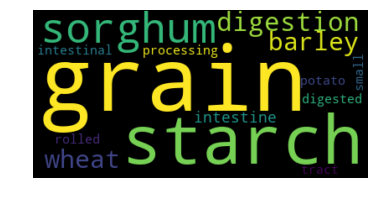

In [40]:

from wordcloud import WordCloud

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
#d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Read the whole text.
text = 'starch grain sorghum digestion barley wheat intestine processing small grains tract intestinal digested potato rolled'

# Generate a word cloud image
wordcloud = WordCloud(collocations=False).generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# # lower max_font_size
# wordcloud = WordCloud(max_font_size=40).generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

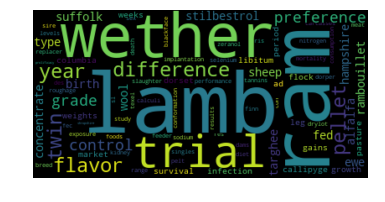

In [42]:
# visualize a topic by putting the top 100 words within a topic in a wordcloud
# size corresponds to rank by weight, but size difference is not proportional to weight difference
from wordcloud import WordCloud
nmf_topic_words100 = [topic[:100] for topic in np.argsort(-abstracts_nmf.components_)]
topic_words = " ".join([abstracts_vocab[idx].strip() for idx in nmf_topic_words100[20]])
wordcloud = WordCloud(collocations=False).generate(topic_words) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [43]:
words_per_component = [np.sum(abstracts_nmf.components_[i] > 0) for i in range(len(abstracts_nmf.components_))]

'iVBORw0KGg'

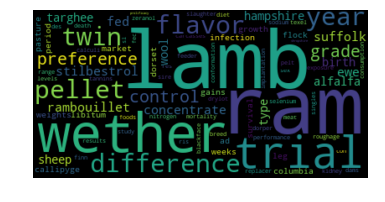

In [45]:
import io
import base64
nmf_topic_words100 = [topic[:100] for topic in np.argsort(-abstracts_nmf.components_)]
topic_words = " ".join([abstracts_vocab[idx].strip() for idx in nmf_topic_words100[20]])
wordcloud = WordCloud(collocations=False).generate(topic_words) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
img = io.BytesIO()
wordcloud.to_image().save(img, 'PNG')
img.seek(0)
lot_url = base64.b64encode(img.getvalue()).decode()
lot_url[:10]

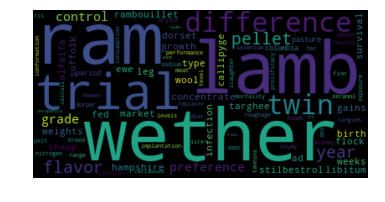

In [49]:
# take a plt generated image and save it as as html

import io
import base64


nmf_topic_words100 = [topic[:100] for topic in np.argsort(-abstracts_nmf.components_)]
topic_words = " ".join([abstracts_vocab[idx].strip() for idx in nmf_topic_words100[20]])
wordcloud = WordCloud(collocations=False).generate(topic_words) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
img = io.BytesIO()
wordcloud.to_image().save(img, 'PNG')
img.seek(0)
lot_url = base64.b64encode(img.getvalue()).decode()

# return '<img src="data:image/png;base64,{}">'.format(plot_url)

